In [3]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
# Input file path for your non-adjusted stock price history
input_file_path = 'company_data/C38U.SI_stock_price_history_non_adj.csv'

# --- 1. Load the Data from your CSV file ---
print(f"Attempting to load data from: {input_file_path}")
try:
    df = pd.read_csv(input_file_path)
    print("Successfully loaded data.")
except FileNotFoundError:
    print(f"Error: The file at {input_file_path} was not found. Please check the path and filename.")
    exit() # Exit the script if the file isn't found
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    exit()

# --- 2. Initial Data Preparation: Ensure Correct Data Types and Set Index ---
print("\nPerforming initial data preparation (Date conversion, setting index, numeric coercion)...")
# df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True) 
df['Date'] = pd.to_datetime(df_stock_price['Date'], infer_datetime_format=True).dt.date

# Set 'Date' as the index and sort it, which is crucial for time-series operations
df = df.set_index('Date').sort_index()

# Ensure Open, High, Low, Close, and Volume columns are numeric.
# Using errors='coerce' will turn any non-convertible values into NaN (Not a Number).
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Remove commas from the 'Volume' column first, then convert to numeric
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False)
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

print("\n--- Initial Data Snapshot ---")
print(df.head())
print("\n--- Initial Data Info ---")
print(df.info())
print(f"Total rows loaded: {len(df)}")


# --- 3. Data Cleaning: Remove Non-Trading (e.g., Dividend/Split) Rows and Handle Duplicates ---

print("\n--- Starting Data Cleaning Process ---")
initial_row_count = len(df)

# Step 3.1: Identify and Remove Rows Likely Representing Non-Trading Events
# Common indicators for non-trading/dividend rows: Volume is 0 or NaN, or Close price is NaN.
print(f"\nChecking for non-trading rows (Volume 0/NaN or Close NaN)...")
non_trading_rows_mask = (df['Volume'] == 0) | (df['Volume'].isna()) | (df['Close'].isna())

num_non_trading_rows = non_trading_rows_mask.sum()
print(f"Found {num_non_trading_rows} rows likely representing non-trading events.")

# Keep only the rows that are NOT identified as non-trading events.
df = df[~non_trading_rows_mask].copy() # Use .copy() to ensure it's a new DataFrame and avoid warnings

rows_removed_events = initial_row_count - len(df)
if rows_removed_events > 0:
    print(f"Removed {rows_removed_events} non-trading event rows.")
else:
    print("No non-trading event rows found or removed.")

# Step 3.2: Handle Any Remaining Date Duplicates (after removing event rows)
print(f"\nChecking for remaining duplicate dates after non-trading event removal...")
rows_before_duplicate_check = len(df)

# Identify all rows where the index (Date) is duplicated, marking all occurrences.
duplicate_dates_mask = df.index.duplicated(keep=False)
num_duplicate_dates = duplicate_dates_mask.sum()
print(f"Found {num_duplicate_dates} rows with duplicate dates (counting all instances) for removal.")

# Filter the DataFrame to keep only non-duplicate index entries, keeping the first occurrence.
df = df[~df.index.duplicated(keep='first')]

rows_removed_duplicates = rows_before_duplicate_check - len(df)
if rows_removed_duplicates > 0:
    print(f"Removed {rows_removed_duplicates} remaining duplicate date entries.")
else:
    print("No remaining duplicate dates found or removed.")

# Final check for any critical NaNs that might have been missed or introduced.
# This ensures that essential columns for calculations are clean.
df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
print(f"\nTotal rows after all initial cleaning steps: {len(df)}")

print("\n--- Data after Cleaning Snapshot ---")
print(df.head())
print("\n--- Data Info after Cleaning ---")
print(df.info())



Attempting to load data from: company_data/C38U.SI_stock_price_history_non_adj.csv
Successfully loaded data.

Performing initial data preparation (Date conversion, setting index, numeric coercion)...


NameError: name 'df_stock_price' is not defined


--- Loading the trained model from 'univariate_lstm_model_base_model.keras' ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 180, 32)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 180, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,653 (154.90 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,436 (103.27 KB)


Evaluating the loaded model on the test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Root Mean Squared Error (RMSE): 0.0284
Mean Absolute Error (MAE): 0.0217


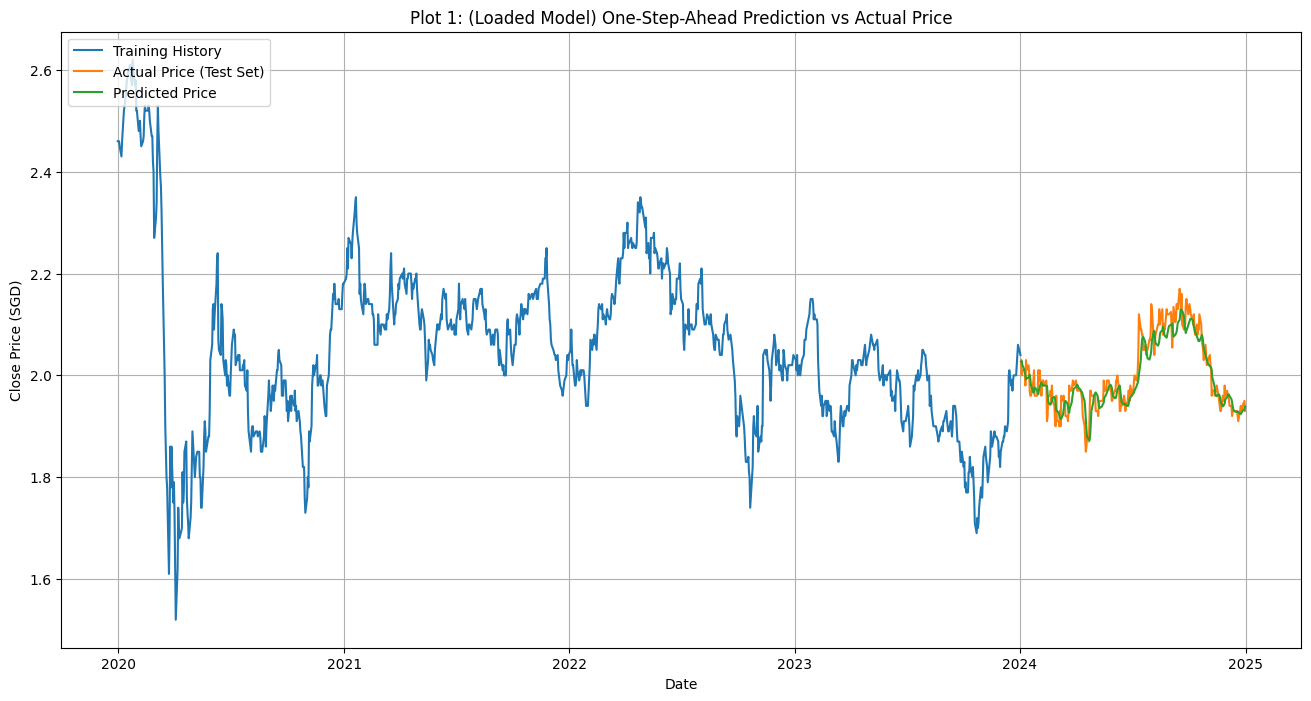


--- Starting 90-day forecast backtest with loaded model ---


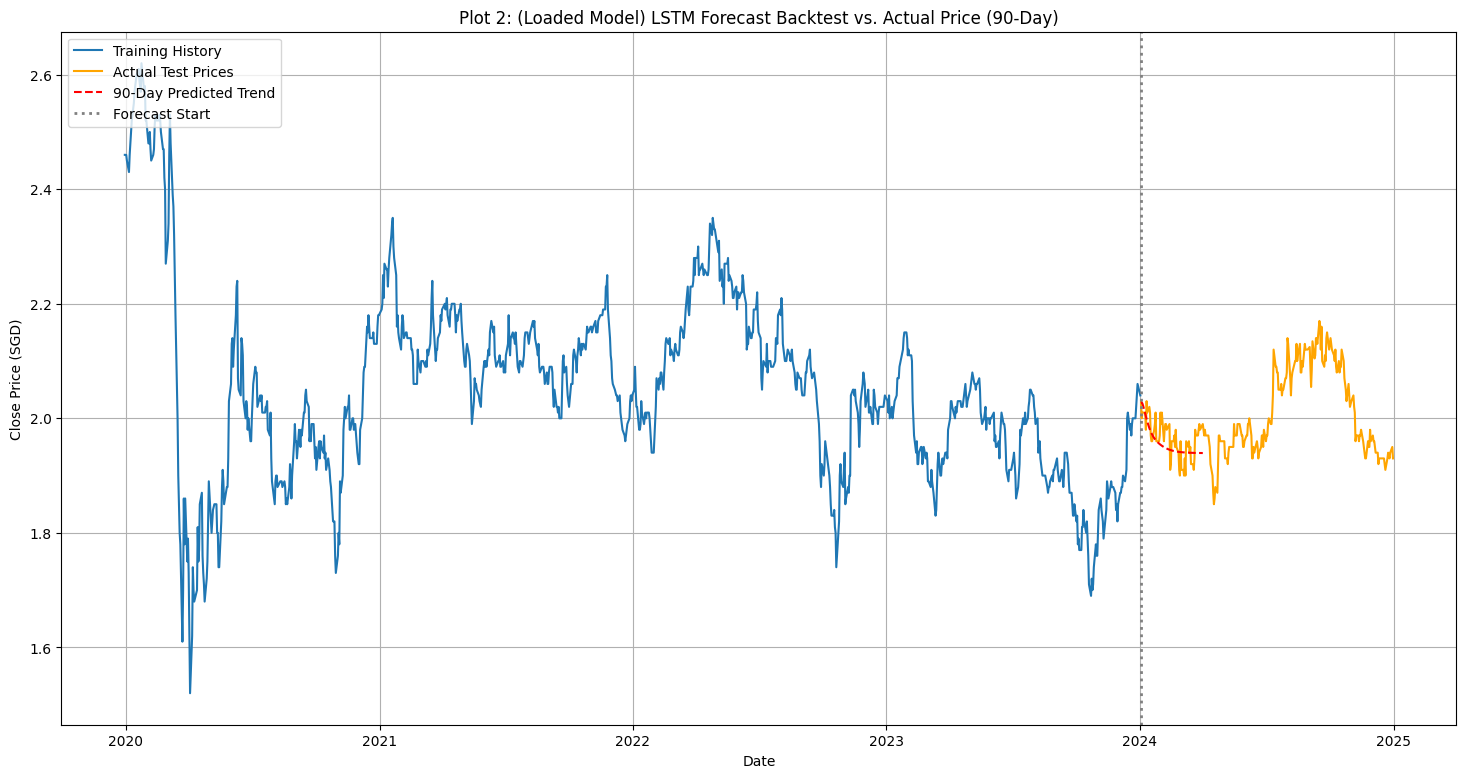

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model # 

# --- 1. Load and Prepare Data ---
# try:
#     df = pd.read_csv('calculated_averages/C38U.SI_stock_price_history_with_indicators.csv', parse_dates=['Date'], index_col='Date')
# except FileNotFoundError:
#     print("Error: CSV file not found. Please check that the file path is correct.")
#     exit()

data = df.filter(['Close'])
dataset = data.values

# Create and fit the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- 2. Load the Pre-trained Model ---
# This replaces the 'Build Model' and 'Train Model' sections
try:
    print("\n--- Loading the trained model from 'univariate_lstm_model_base_model.keras' ---")
    model = load_model('univariate_lstm_model_base_model.keras')
    model.summary()
except OSError:
    print("Error: Model file 'univariate_lstm_model_base_model.keras' not found. Please run the training script first.")
    exit()


# --- THE REST OF THE SCRIPT FOR EVALUATION AND FORECASTING IS THE SAME ---

# --- Define constants needed for the script ---
SEQ_LEN = 180
train_data_len = int(np.ceil(len(dataset) * .8))


# --------------------------------------------------------------------------------------
# --- PART A: ONE-STEP-AHEAD EVALUATION ON TEST SET ---
# --------------------------------------------------------------------------------------

# --- 3. Create the Testing Data Set ---
test_data = scaled_data[train_data_len - SEQ_LEN:, :]
x_test = []
y_test = dataset[train_data_len:, :]

for i in range(SEQ_LEN, len(test_data)):
    x_test.append(test_data[i-SEQ_LEN:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# --- 4. Get the Model's Predicted Price Values ---
print("\nEvaluating the loaded model on the test set...")
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# --- 5. Evaluate Model Performance ---
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# --- 6. Visualize the Test Set Predictions ---
train_plot_data = data[:train_data_len]
valid_plot_data = data[train_data_len:].copy()
valid_plot_data['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Plot 1: (Loaded Model) One-Step-Ahead Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price (SGD)')
plt.plot(train_plot_data['Close'], label='Training History')
plt.plot(valid_plot_data['Close'], label='Actual Price (Test Set)')
plt.plot(valid_plot_data['Predictions'], label='Predicted Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# --------------------------------------------------------------------------------------
# --- PART B: 90-DAY FORECAST BACKTEST ---
# --------------------------------------------------------------------------------------

# --- 7. Perform Iterative Forecasting for Backtest ---
N_STEPS_BACKTEST = 90
print(f"\n--- Starting {N_STEPS_BACKTEST}-day forecast backtest with loaded model ---")

initial_sequence_backtest = scaled_data[train_data_len - SEQ_LEN : train_data_len, :]
current_input_backtest = initial_sequence_backtest.reshape(1, SEQ_LEN, 1)
backtest_predictions_scaled = []

for i in range(N_STEPS_BACKTEST):
    next_prediction_scaled = model.predict(current_input_backtest, verbose=0)[0, 0]
    backtest_predictions_scaled.append(next_prediction_scaled)
    
    new_input_list = current_input_backtest[0, :, 0].tolist()
    new_input_list.pop(0)
    new_input_list.append(next_prediction_scaled)
    current_input_backtest = np.array(new_input_list).reshape(1, SEQ_LEN, 1)

# --- 8. Visualize the Backtest Forecast ---
backtest_array = np.array(backtest_predictions_scaled).reshape(-1, 1)
backtest_predictions_price = scaler.inverse_transform(backtest_array)

forecast_start_date = data.index[train_data_len]
backtest_dates = pd.date_range(start=forecast_start_date, periods=N_STEPS_BACKTEST)
backtest_df = pd.DataFrame(backtest_predictions_price, index=backtest_dates, columns=['Backtest_Forecast'])

train = data[:train_data_len]
valid = data[train_data_len:]

plt.figure(figsize=(18, 9))
plt.title(f'Plot 2: (Loaded Model) LSTM Forecast Backtest vs. Actual Price ({N_STEPS_BACKTEST}-Day)')
plt.xlabel('Date')
plt.ylabel('Close Price (SGD)')
plt.plot(train['Close'], label='Training History')
plt.plot(valid['Close'], label='Actual Test Prices', color='orange')
plt.plot(backtest_df['Backtest_Forecast'], label=f'{N_STEPS_BACKTEST}-Day Predicted Trend', color='red', linestyle='--')
plt.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Start')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()